# Modeling Strategy

> 1.	Individual Models for Different Labels:

>   •	Binary Top-4 Model (Model A):

>.   Predicts whether a horse finishes in the top 4 (1) or not (0).

>	•	Binary Win Model (Model B):
>.   Predicts whether the horse wins (1) or not (0).
	
>    •	Ordinal Model (Model C):

> Attempts to predict the exact finishing position (e.g., a regression model outputting a continuous value you can round to an integer, or an ordinal classification model that outputs probabilities for each rank).

>    •	Multi-Class Model (Model D):

>.   Classifies a horse into one of several buckets:

>.   •	Class 0: Winner (finish = 1)

>.   •	Class 1: Top-3 but not win (2 ≤ finish ≤ 3)

>.   •	Class 2: Top-4 but not top-3 (finish = 4)

>.   •	Class 3: Outside top-4 (finish > 4)

> 2.	Ensembling the Results:
After training these models, you’ll have a set of predictions per horse. For example, from a single race:

>.   •	Model A gives a probability of top-4 (P(top4))

>.   •	Model B gives a probability of winning (P(win))

>.   •	Model C gives a predicted finishing position or a probability distribution over positions (depending on the approach)

>.   •	Model D gives probabilities for each of the four categories (P(win), P(top3_not_win), P(top4_not_top3), P(outside_top4))
	
> 3.	Combining Predictions:

>.   You can combine these outputs using:

>.   •	A Weighted Average or Voting Scheme:

> For instance, to estimate the probability of finishing 1st, you might weigh Model B’s probability of winning heavily, and also consider Model D’s probability for the “win” class. If both strongly indicate a win, you trust that horse as a likely winner.

> •	Decision Rules:
For example:

•	If Model B’s P(win) is high and Model D also puts most probability mass on “win” class, that horse is likely first.

•	If Model A’s P(top4) is high but Model B’s P(win) is low, and Model D suggests a class in top 4 but not top 3, you can infer something about its likely finishing bracket.

•	A Second-Level Model (Stacking):
You could train another model (e.g., a logistic regression or another XGBoost) that takes as input the predictions from all the above models and outputs a refined probability distribution over exact finishes or top-4 ordering. This “meta-model” learns how best to combine the signals from each specialized model.

> 4.	Interpreting the Final Outcome for First Four Positions:

With the combined predictions, you could:

•	Rank horses by their predicted probability of being the winner.

•	Among the remaining horses, rank them by their predicted probability of making top-3 or top-4, etc.

Essentially, by merging the signals from these various target definitions, you might get a more robust and nuanced understanding of each horse’s chances. For instance:

•	Model B and D give good signals for the winner.

•	Model A and D help solidify who belongs in the top-4 bracket.

•	Model C could refine ordering among the top candidates if it provides a direct finishing position estimate.


In [3]:
# Setup Environment

import os
import logging
import xgboost
from pyspark.sql.functions import (col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as spark_min, max as spark_max , 
                                   row_number, mean, countDistinct, last, first)
import configparser
from pyspark.sql import SparkSession
from src.data_preprocessing.data_prep1.sql_queries import sql_queries
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql, reload_parquet_files
from pyspark.sql.window import Window
from pyspark.sql import DataFrame, Window
from src.data_preprocessing.data_prep1.data_utils import (save_parquet, gather_statistics, 
                initialize_environment, load_config, initialize_logging, initialize_spark, 
                identify_and_impute_outliers, 
                identify_and_remove_outliers, identify_missing_and_outliers)
# Set global references to None
spark = None
master_results_df = None
sectional_results = None
results = None

In [4]:
spark, jdbc_url, jdbc_properties, queries, parquet_dir, log_file = initialize_environment()

2024-12-30 10:28:16,990 - INFO - Environment setup initialized.
24/12/30 10:28:17 WARN Utils: Your hostname, mail.relufox.ai resolves to a loopback address: 127.0.0.1; using 192.168.4.25 instead (on interface eno2)
24/12/30 10:28:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/12/30 10:28:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/30 10:28:18 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/12/30 10:28:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/12/30 10:28:18 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
24/12/30 10:28:18 WARN Utils:

Spark session created successfully.


In [5]:
results = spark.read.parquet(os.path.join(parquet_dir, "results.parquet"))

In [6]:
results.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- horse_name: string (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- purse: integer (nullable = true)
 |-- wps_pool: decimal(10,2) (nullable = true)
 |-- weight: decimal(10,2) (nullable = true)
 |-- date_of_birth: date (nullable = true)
 |-- sex: string (nullable = true)
 |-- start_position: long (nullable = true)
 |-- equip: string (nullable = true)
 |-- claimprice: double (nullable = true)
 |-- surface: string (nullable = true)
 |-- surface_type_description: string (nullable = true)
 |-- trk_cond: string (nullable = true)
 |-- trk_cond_desc: string (nullable = true)
 |-- weather: string (nullable = true)
 |-- distance: decimal(10,2) (nullable = true)
 |-- dist_unit: string (nullable = true)
 |-- power: decimal(10,2) (nullable = true)
 |-- med: 

# Everything below is scratch pad and not part of this analysis

In [7]:
gpspoint = spark.read.parquet(os.path.join(parquet_dir, "gpspoint.parquet"))

In [11]:
sectionals = spark.read.parquet(os.path.join(parquet_dir, "sectionals.parquet"))

In [12]:
sectionals.printSchema()

root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)



In [129]:
#merge_results_sectionals.printSchema()

1.	Convert a Small Subset to Pandas:
Spark DataFrames are generally too large to visualize directly. Instead, select a manageable sample or a single race and convert it to a Pandas DataFrame. For example:

In [25]:
import pandas as pd

# Path to your Parquet file
parquet_path = "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/merged_df.parquet"

# Read Parquet file into a Pandas DataFrame
pandas_df = pd.read_parquet(parquet_path)

# Check the loaded data
print(pandas_df.info())
print(pandas_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1456952 entries, 0 to 1456951
Data columns (total 70 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   course_cd                     1456952 non-null  object        
 1   race_date                     1456952 non-null  object        
 2   race_number                   1456952 non-null  int32         
 3   saddle_cloth_number           1456952 non-null  object        
 4   sectionals_gate_name          1456952 non-null  object        
 5   official_fin                  1456952 non-null  int32         
 6   purse                         1456952 non-null  int32         
 7   wps_pool                      1456952 non-null  object        
 8   weight                        1456952 non-null  object        
 9   date_of_birth                 1456952 non-null  object        
 10  sex                           1456952 non-null  object        
 11

In [51]:

print(pandas_df["race_date"].dtype)  # Check the data type of race_date

object


In [52]:
pandas_df["race_date"] = pd.to_datetime(pandas_df["race_date"])

Use Python Plotting Libraries (e.g., Matplotlib, Seaborn, Plotly):
With pandas_df, you can use standard Python data visualization libraries:

In [113]:
import pandas as pd

# Group by the desired columns and sort within each group by `sectionals_gate_numeric`
grouped_sorted_df = (
    pandas_df
    .sort_values(by=["course_cd", "race_date", "race_number", "saddle_cloth_number", "sectionals_gate_numeric"])
)

# If you want to filter specific conditions before sorting
filtered_df = pandas_df[
    (pandas_df["course_cd"] == "AQU") &
    (pandas_df["race_date"] == pd.Timestamp("2024-02-17")) &
    (pandas_df["race_number"] == 5)] # &
#    (pandas_df["saddle_cloth_number"] == "2")
#]

# Apply sorting on the filtered DataFrame
grouped_sorted_filtered_df = (
    filtered_df
    .sort_values(by=["course_cd", "race_date", "race_number", "saddle_cloth_number", "sectionals_gate_numeric"])
)

# Display the result
# print(grouped_sorted_filtered_df)

In [114]:
print(pandas_df["saddle_cloth_number"].unique())

['1' '5' '2' '6' '7' '4' '9' '3' '8' '10' '11' '1A' '12' '13' '14' '2B'
 '15' '16']


In [115]:
pandas_df["saddle_cloth_number"] = pandas_df["saddle_cloth_number"].astype(str).str.strip()

In [116]:
print(pandas_df[pandas_df["course_cd"] == "AQU"].shape)
print(pandas_df[pandas_df["race_date"] == pd.Timestamp("2024-02-17")].shape)
print(pandas_df[pandas_df["race_number"] == 2].shape)
print(pandas_df[pandas_df["saddle_cloth_number"] == "1"].shape)

(72066, 70)
(2779, 70)
(156302, 70)
(186605, 70)


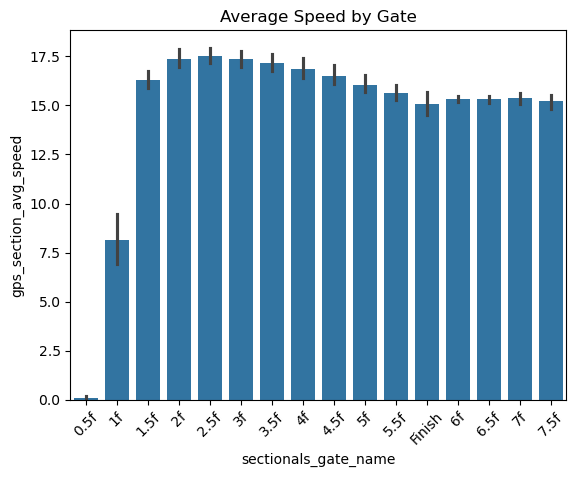

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Plot avg speed by gate
sns.barplot(data=grouped_sorted_filtered_df, x="sectionals_gate_name", y="gps_section_avg_speed")
plt.xticks(rotation=45)
plt.title("Average Speed by Gate")
plt.show()

3.	Visualize Race Progression Over Time:
If you have time-based columns like sec_time_stamp, you can plot how speed or stride_frequency changes over time:

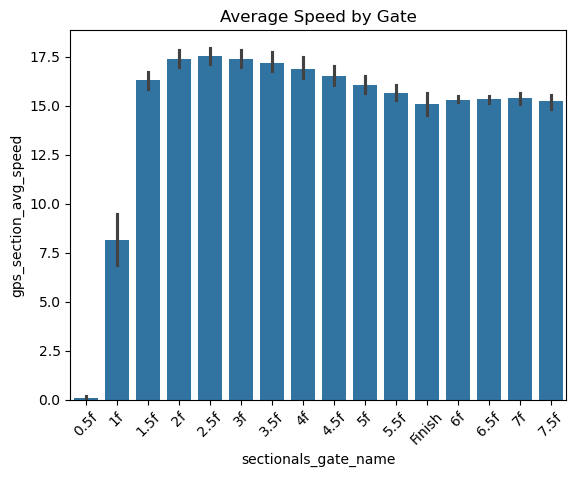

In [118]:
grouped_sorted_filtered_df

# Example: Plot avg speed by gate
sns.barplot(data=grouped_sorted_filtered_df, x="sectionals_gate_name", y="gps_section_avg_speed")
plt.xticks(rotation=45)
plt.title("Average Speed by Gate")
plt.show()

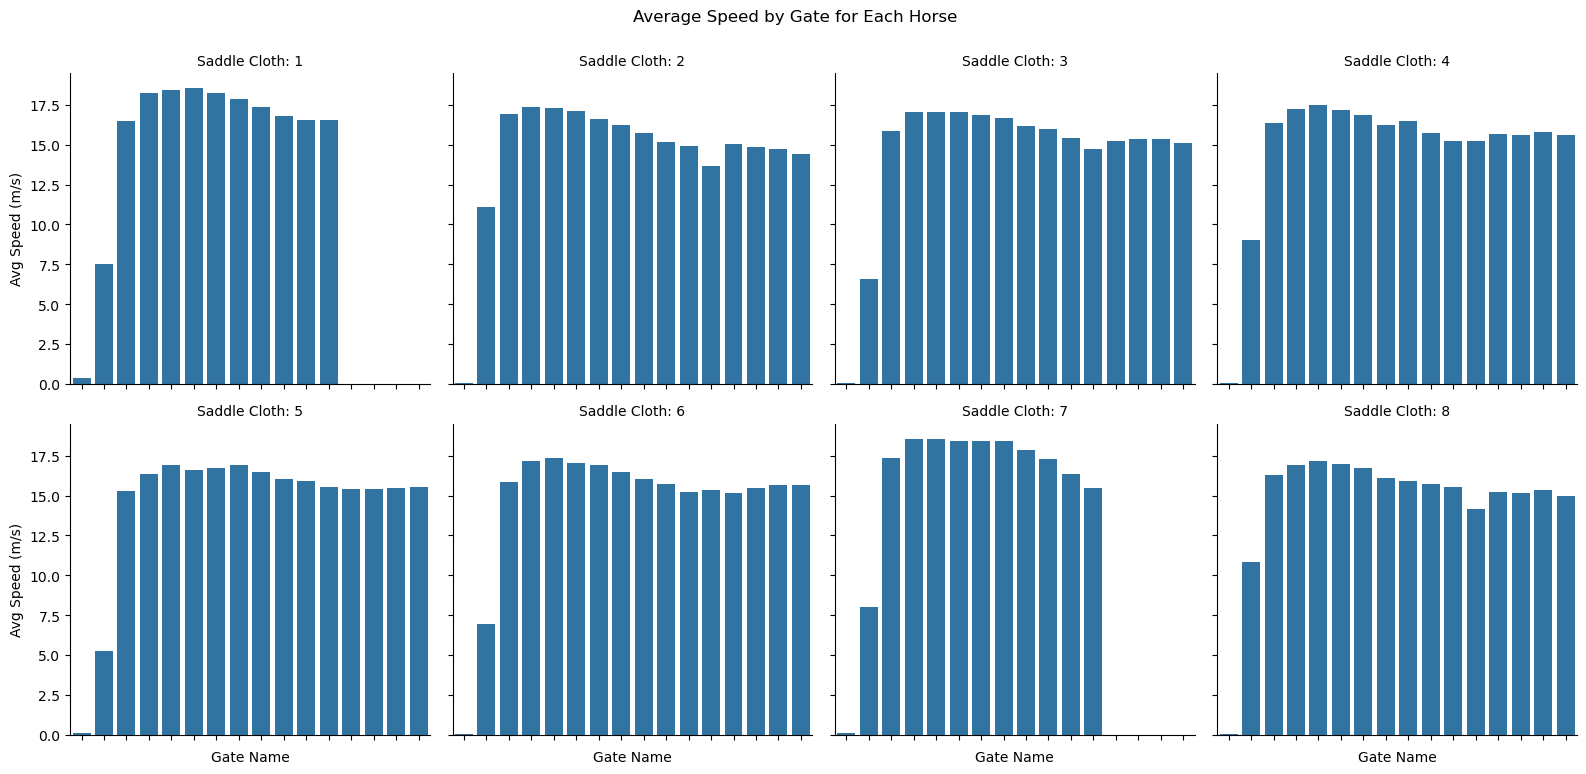

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure sectionals_gate_name is sorted for better plotting
grouped_sorted_filtered_df = grouped_sorted_filtered_df.sort_values(by=["saddle_cloth_number", "sectionals_gate_numeric"])

# Create a grid of plots with one plot per horse (saddle_cloth_number)
g = sns.FacetGrid(
    grouped_sorted_filtered_df,
    col="saddle_cloth_number",
    col_wrap=4,  # Adjust the number of columns in the grid
    sharey=True,  # Share the y-axis across all plots
    height=4      # Height of each subplot
)

# Plot avg speed for each gate within each horse's plot
g.map(sns.barplot, "sectionals_gate_name", "gps_section_avg_speed", order=grouped_sorted_filtered_df["sectionals_gate_name"].unique())

# Customize the grid
g.set_titles("Saddle Cloth: {col_name}")
g.set_axis_labels("Gate Name", "Avg Speed (m/s)")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.9)  # Adjust space at the top
g.fig.suptitle("Average Speed by Gate for Each Horse")

# Show the plot
plt.show()

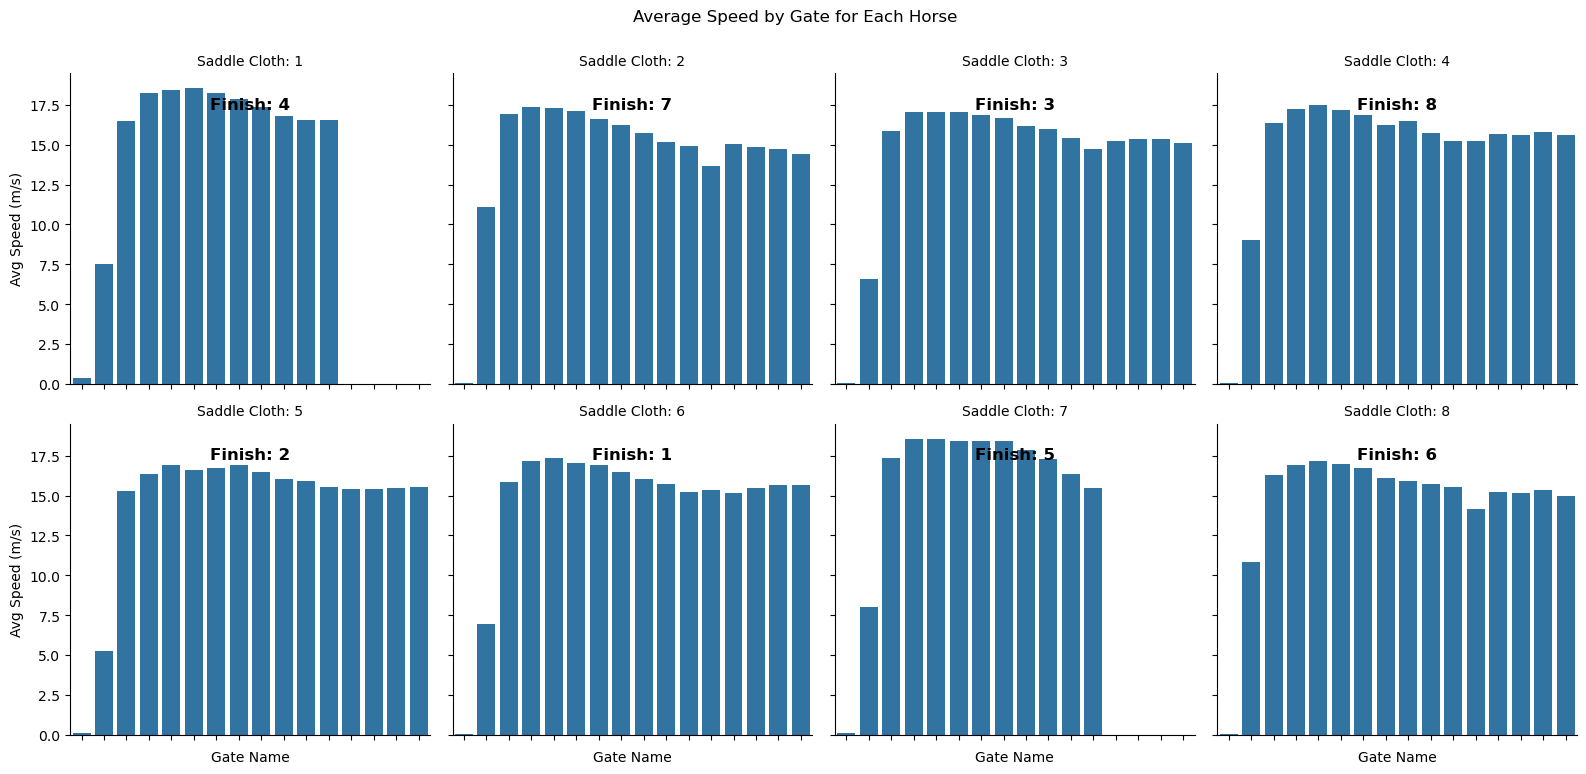

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure sectionals_gate_name is sorted for better plotting
grouped_sorted_filtered_df = grouped_sorted_filtered_df.sort_values(by=["saddle_cloth_number", "sectionals_gate_numeric"])

# Create a grid of plots with one plot per horse (saddle_cloth_number)
g = sns.FacetGrid(
    grouped_sorted_filtered_df,
    col="saddle_cloth_number",
    col_wrap=4,  # Adjust the number of columns in the grid
    sharey=True,  # Share the y-axis across all plots
    height=4      # Height of each subplot
)

# Plot avg speed for each gate within each horse's plot
g.map(sns.barplot, "sectionals_gate_name", "gps_section_avg_speed", order=grouped_sorted_filtered_df["sectionals_gate_name"].unique())

# Add custom titles with official_fin
for ax, (saddle_cloth_number, sub_df) in zip(g.axes.flat, grouped_sorted_filtered_df.groupby("saddle_cloth_number")):
    # Extract the official_fin value for this horse (assuming it's consistent within a horse's group)
    official_fin = sub_df["official_fin"].iloc[0]
    # Add text to the plot
    ax.text(
        0.5,  # X-coordinate (center of the plot)
        0.9,  # Y-coordinate (90% of the height)
        f"Finish: {official_fin}",  # Text content
        fontsize=12,
        weight="bold",
        ha="center",  # Horizontal alignment
        va="center",  # Vertical alignment
        transform=ax.transAxes,  # Transform coordinates to Axes-relative
    )

# Customize the grid
g.set_titles("Saddle Cloth: {col_name}")
g.set_axis_labels("Gate Name", "Avg Speed (m/s)")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.9)  # Adjust space at the top
g.fig.suptitle("Average Speed by Gate for Each Horse")

# Show the plot
plt.show()

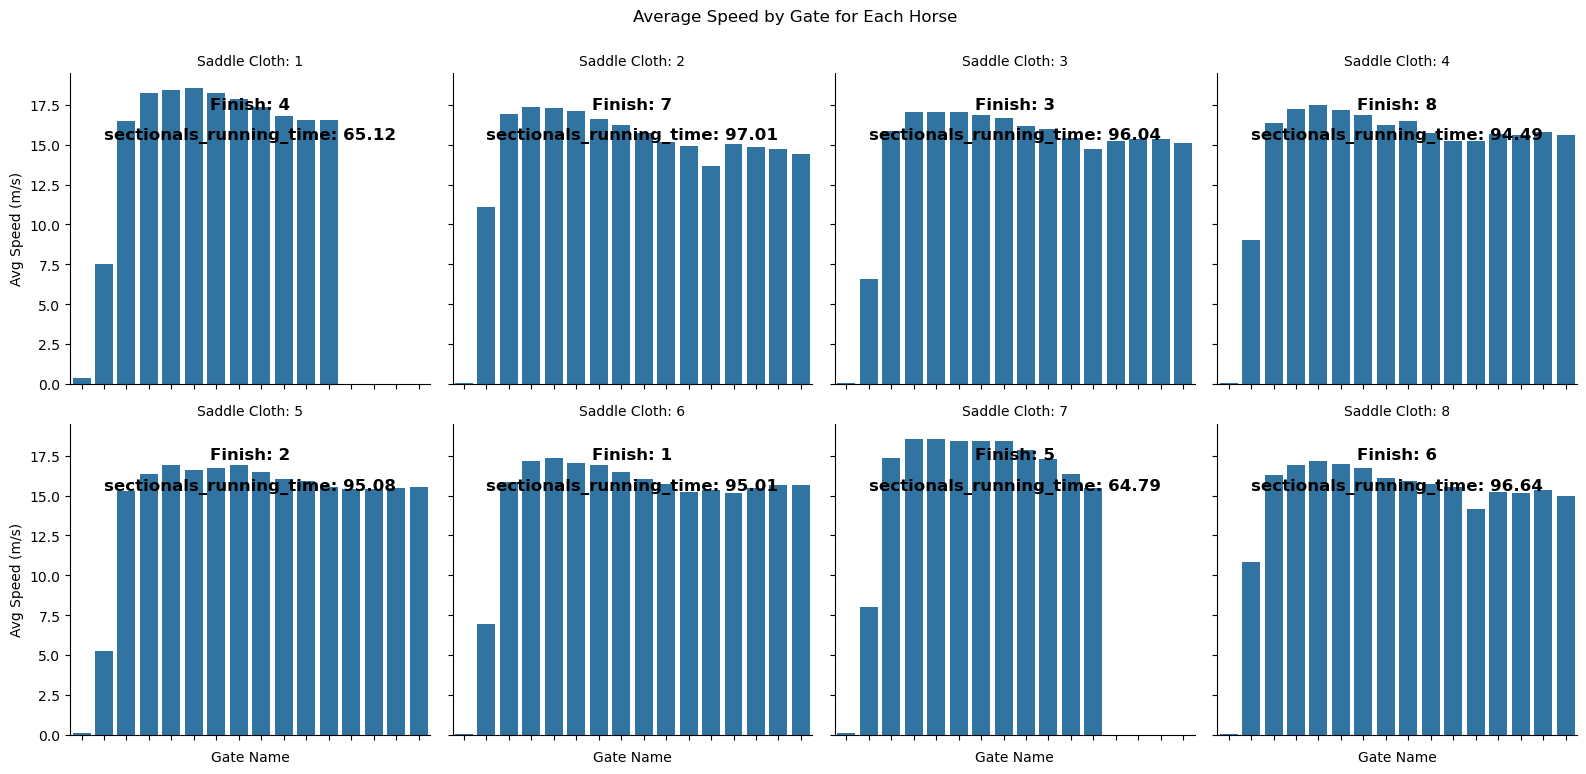

In [121]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure sectionals_gate_name is sorted for better plotting
grouped_sorted_filtered_df = grouped_sorted_filtered_df.sort_values(by=["saddle_cloth_number", "sectionals_gate_numeric"])

# Create a grid of plots with one plot per horse (saddle_cloth_number)
g = sns.FacetGrid(
    grouped_sorted_filtered_df,
    col="saddle_cloth_number",
    col_wrap=4,  # Adjust the number of columns in the grid
    sharey=True,  # Share the y-axis across all plots
    height=4      # Height of each subplot
)

# Plot avg speed for each gate within each horse's plot
g.map(sns.barplot, "sectionals_gate_name", "gps_section_avg_speed", order=grouped_sorted_filtered_df["sectionals_gate_name"].unique())

# Add custom titles with official_fin and avgspd
for ax, (saddle_cloth_number, sub_df) in zip(g.axes.flat, grouped_sorted_filtered_df.groupby("saddle_cloth_number")):
    # Extract the official_fin value for this horse (assuming it's consistent within a horse's group)
    official_fin = sub_df["official_fin"].iloc[0]
    sectionals_running_time = sub_df["sectionals_running_time"].iloc[0]  # Extract avgspd for the horse

    # Add the official finish text
    ax.text(
        0.5,  # X-coordinate (center of the plot)
        0.9,  # Y-coordinate (90% of the height)
        f"Finish: {official_fin}",  # Text content
        fontsize=12,
        weight="bold",
        ha="center",  # Horizontal alignment
        va="center",  # Vertical alignment
        transform=ax.transAxes,  # Transform coordinates to Axes-relative
    )

    # Add the avgspd text right below the official finish
    ax.text(
        0.5,  # X-coordinate (center of the plot)
        0.8,  # Y-coordinate (80% of the height)
        f"sectionals_running_time: {sectionals_running_time:.2f}",  # Display avgspd rounded to 2 decimals
        fontsize=12,
        weight="bold",
        ha="center",  # Horizontal alignment
        va="center",  # Vertical alignment
        transform=ax.transAxes,  # Transform coordinates to Axes-relative
    )

# Customize the grid
g.set_titles("Saddle Cloth: {col_name}")
g.set_axis_labels("Gate Name", "Avg Speed (m/s)")
g.set_xticklabels(rotation=45)
g.fig.subplots_adjust(top=0.9)  # Adjust space at the top
g.fig.suptitle("Average Speed by Gate for Each Horse")

# Show the plot
plt.show()

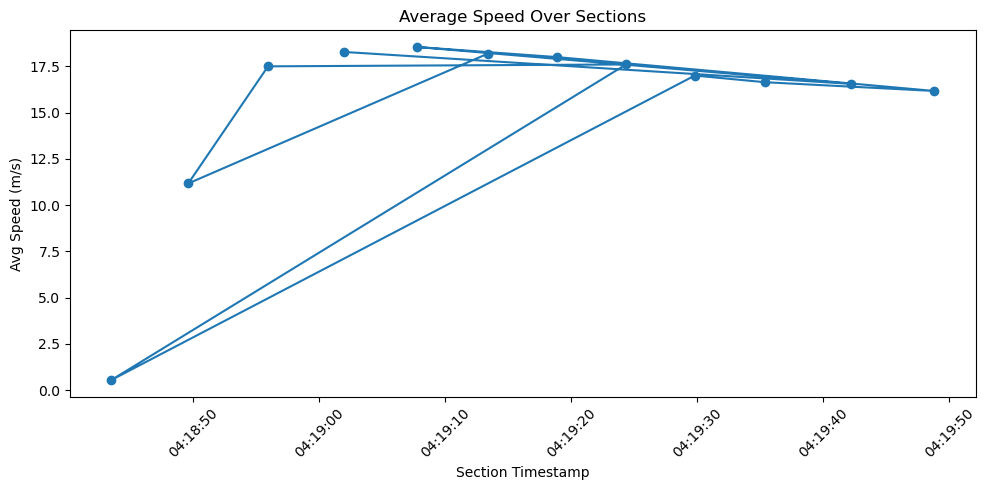

In [128]:
# Sort by time
grouped_sorted_filtered_df = limited_df.sort_values(by="sec_time_stamp")

plt.figure(figsize=(10,5))
plt.plot(limited_df["sec_time_stamp"], limited_df["gps_section_avg_speed"], marker='o')
plt.xticks(rotation=45)
plt.title("Average Speed Over Sections")
plt.xlabel("Section Timestamp")
plt.ylabel("Avg Speed (m/s)")
plt.tight_layout()
plt.show()

	4.	Check Acceleration Patterns:
If you’ve computed average acceleration per section, you can plot a line chart of acceleration over the race sections:

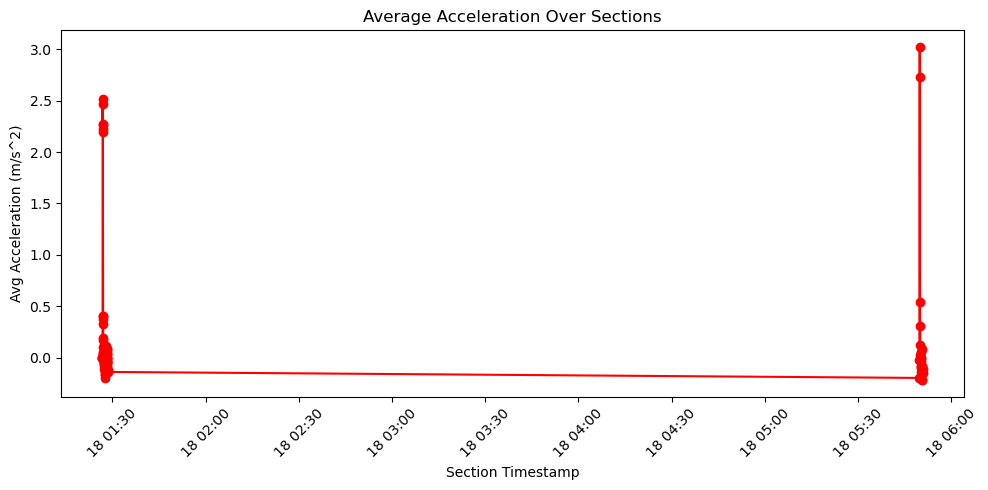

In [123]:
plt.figure(figsize=(10,5))
plt.plot(grouped_sorted_filtered_df["sec_time_stamp"], grouped_sorted_filtered_df["gps_avg_acceleration"], marker='o', color='red')
plt.xticks(rotation=45)
plt.title("Average Acceleration Over Sections")
plt.xlabel("Section Timestamp")
plt.ylabel("Avg Acceleration (m/s^2)")
plt.tight_layout()
plt.show()

	5.	Mapping Horse Locations on a Track (Optional):
If you have longitude/latitude data and a small subset, you can visualize the horse’s path. Convert the gps_first_location or gps_last_location into separate longitude/latitude columns (if they are WKT POINT strings, parse them). For example, if gps_first_location is a WKT “POINT (lon lat)”, you might extract coordinates using Python string operations:

In [81]:
# Assuming gps_first_location is something like "POINT (lon lat)"
grouped_sorted_filtered_df["gps_first_lon"] = grouped_sorted_filtered_df["gps_first_location"].apply(lambda s: float(s.split("(")[1].split(" ")[0]))
grouped_sorted_filtered_df["gps_first_lat"] = grouped_sorted_filtered_df["gps_first_location"].apply(lambda s: float(s.split("(")[1].split(" ")[1].replace(")","")))

plt.figure(figsize=(6,6))
plt.scatter(grouped_sorted_filtered_df["gps_first_lon"], grouped_sorted_filtered_df["gps_first_lat"], c='blue', marker='o')
plt.title("First GPS Location in Each Section")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

IndexError: list index out of range

	6.	Interactive Tools (Jupyter Notebook):
If you’re in a Jupyter environment, you can use Plotly or other interactive visualization tools to gain more insight.

In Summary:
	•	Convert a manageable subset of your Spark DataFrame to Pandas.
	•	Use standard Python libraries to plot speed, acceleration, stride frequency, etc., against time or section indices.
	•	If geographic visualization is desired, parse coordinates and plot them on a scatter plot or use a map visualization library.

This approach will help you see if the results line up with expectations (e.g., speeds increasing or decreasing logically, acceleration patterns making sense, locations along the track consistent).

# Everything above is scratch pad and not part of this analysis

# Data Analysis

Before beginning here, go to /src/data_preprocessing/data_prep2/main_data_prep2.py and run data_check and cardinality reports. 

### Convert decimal columns to float

In [ ]:
#distinct_distances = results.select("distance", "dist_unit").distinct()
#distinct_distances.show(1000)

In [ ]:
results = results.withColumn("distance", col("distance").cast("double"))
results = results.withColumn("wps_pool", col("wps_pool").cast("double"))
results = results.withColumn("weight", col("weight").cast("double"))
results = results.withColumn("power", col("power").cast("double"))
results = results.withColumn("morn_odds", col("morn_odds").cast("double"))
results = results.withColumn("all_earnings", col("all_earnings").cast("double"))
results = results.withColumn("cond_earnings", col("cond_earnings").cast("double"))


### date_of_birth: Impute with Global median

In [ ]:
from pyspark.sql.functions import col, lit, count, expr
from pyspark.sql.window import Window

# Convert date_of_birth to a numeric timestamp for median calculation
results = results.withColumn("date_of_birth_ts", col("date_of_birth").cast("timestamp").cast("long"))

# Calculate the median of date_of_birth
median_window = Window.orderBy("date_of_birth_ts")
row_count = results.filter(col("date_of_birth_ts").isNotNull()).count()

if row_count % 2 == 0:  # Even number of rows
    median_row_1 = row_count // 2
    median_row_2 = median_row_1 + 1
    median_ts = results.filter(col("date_of_birth_ts").isNotNull()) \
        .select("date_of_birth_ts") \
        .withColumn("row_num", expr("row_number() over (ORDER BY date_of_birth_ts)")) \
        .filter((col("row_num") == median_row_1) | (col("row_num") == median_row_2)) \
        .groupBy().agg(expr("avg(date_of_birth_ts)").alias("median_ts")) \
        .collect()[0]["median_ts"]
else:  # Odd number of rows
    median_row = (row_count + 1) // 2
    median_ts = results.filter(col("date_of_birth_ts").isNotNull()) \
        .select("date_of_birth_ts") \
        .withColumn("row_num", expr("row_number() over (ORDER BY date_of_birth_ts)")) \
        .filter(col("row_num") == median_row) \
        .collect()[0]["date_of_birth_ts"]

# Convert median timestamp back to date
median_date = lit(expr(f"CAST(FROM_UNIXTIME({median_ts}) AS DATE)"))

# Fill missing values with the global median date
results = results.withColumn(
    "date_of_birth",
    when(col("date_of_birth").isNull(), median_date).otherwise(col("date_of_birth"))
).drop("date_of_birth_ts")

In [ ]:
# Show the updated DataFrame
results.filter(col("date_of_birth").isNull()).count()

## Convert DOB to AGE_AT_RACE_DAY

In [ ]:
from pyspark.sql.functions import col, datediff, expr

# Ensure both date_of_birth and race_date are in date format
results = results.withColumn("date_of_birth", col("date_of_birth").cast("date"))
results = results.withColumn("race_date", col("race_date").cast("date"))

# Calculate age in days, then convert to years
results = results.withColumn(
    "age_at_race_day",
    datediff(col("race_date"), col("date_of_birth")) / 365.25  # Convert days to years
)

# Show the updated DataFrame
results.select("date_of_birth", "race_date", "age_at_race_day").show(5)

### Encoding Weather

In [ ]:
# Remember to pay attention to case
results = results.fillna({"weather": "Clear"})
results.filter(col("weather").isNull()).count()

In [ ]:
results.select("weather").distinct().count()
# Count the occurrences of each distinct value in the "weather" column
distinct_value_counts = results.groupBy("weather").count()

# Show the result
distinct_value_counts.show()

### wps_pool: Imputing with mean

In [ ]:
from pyspark.sql.functions import col, mean, when

# Calculate the mean of the 'wps_pool' column, excluding nulls
mean_value = results.select(mean(col("wps_pool")).alias("mean_wps_pool")).collect()[0]["mean_wps_pool"]

# Replace null values in 'wps_pool' with the calculated mean
results = results.withColumn(
    "wps_pool",
    when(col("wps_pool").isNull(), mean_value).otherwise(col("wps_pool"))
)

# Show the updated DataFrame
results.filter(col("wps_pool").isNull()).count()

### equip: Conversion and Imputation

In [ ]:
results = results.fillna({"equip": "No_Equip"})
results.filter(col("equip").isNull()).count()

### trk_cond: Impute

In [ ]:
cols = ["trk_cond", "trk_cond_desc"] 
results.select(cols).distinct().count()

# Count the occurrences of each distinct value in the "weather" column
distinct_value_counts = results.groupBy(cols).count()

# Show the result
distinct_value_counts.show()


In [ ]:
cols = ["trk_cond", "trk_cond_desc"]

# Fill missing values with "MISSING" for the specified columns
results = results.fillna({col: "MISSING" for col in cols})

# Verify no null values remain
missing_count = results.filter(
    (col("trk_cond").isNull()) | (col("trk_cond_desc").isNull())
).count()

print(f"Number of missing values: {missing_count}")

In [ ]:
results = results.drop("trk_cond_desc", "saddle_cloth_number")

### Encoding Sex

Horse Sex 	Code	Description
	C	Colt
	F	Filly
	G	Gelding
	H	Horse
	M	Mare
	R	Ridgling
	B	Spayed Mare

In [ ]:
# "equip", "surface", "surface_type_description", "trk_cond", "trk_cond_desc", "weather", "dist_unit", "race_type"]

cols = ["sex"] 

distinct_values = results.select(*cols).distinct()
distinct_values.show(50)


In [ ]:
from pyspark.sql.functions import trim, col
results = results.withColumn("dist_unit", trim(col("dist_unit")))

In [ ]:
results = results.replace("", "MISSING", subset=["med", "turf_mud_mark"])

In [ ]:
results.filter(col("sex").isNull()).count()

In [ ]:
results = results.drop("surface_type_description", "avgcls")
results = results.drop("trk_cond_desc")

In [ ]:
results = results.drop("horse_name")

In [ ]:
# results = results.drop("saddle_cloth_number")

In [ ]:
cols = ["race_type"] 

distinct_values = results.select(*cols).distinct()
distinct_values.show(50)


In [ ]:
results.printSchema()

# OHE and Prep for XGBoost Trainining in Spark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
import datetime


### Create Label from Official_fin

In [ ]:
# Convert official_fin to binary label for top-4 finish
results = results.withColumn("label", when(col("official_fin") <= 4, 1).otherwise(0))

In [ ]:
# Took out course_cd to see if it would help identify other predictive features.
# Categorical columns equip, surface, trk_cond, weather, dist_unit, race_type 
categorical_cols = ["equip", "surface", "trk_cond", "weather", "dist_unit", "race_type", "sex" , "med", "stk_clm_md", "turf_mud_mark"]
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid="keep") for c in categorical_cols]
encoders = [OneHotEncoder(inputCols=[c+"_index"], outputCols=[c+"_ohe"]) for c in categorical_cols]


In [ ]:
#for c in categorical_cols:
#    distinct_values = results.select(c).distinct().collect()
#    print(c, [row[c] for row in distinct_values])

In [ ]:

results = results.drop("date_of_birth", "official_fin")

In [ ]:
results.printSchema()

In [ ]:
jock_indexer = StringIndexer(inputCol="jock_key", outputCol="jock_key_index", handleInvalid="keep")
train_indexer = StringIndexer(inputCol="train_key", outputCol="train_key_index", handleInvalid="keep")

In [ ]:
# Numeric columns
# Removing "race_number" 
numeric_cols = ["morn_odds", "age_at_race_day",  "purse", "weight", "start_position", 
                "claimprice", "power", "avgspd", "class_rating", "net_sentiment","weight", 
                "distance", "power", "all_earnings", "cond_earnings", "avg_spd_sd", 
                "ave_cl_sd", "hi_spd_sd", "pstyerl", "all_starts", 
               "all_win", "all_place", "all_show", "all_fourth", "cond_starts", 
                "cond_win", "cond_place", "cond_show", "cond_fourth"]
# Add later to numeric cols after normalization: "jock_key_index", "train_key_index", 

### Spark Pipeline

In [ ]:
# Create a pipeline to transform data
preprocessing_stages = [jock_indexer, train_indexer] + indexers + encoders
pipeline = Pipeline(stages=preprocessing_stages)
model = pipeline.fit(results)
df_transformed = model.transform(results)

In [ ]:
ohe_cols = [c+"_ohe" for c in categorical_cols]

In [ ]:
assembler = VectorAssembler(inputCols=numeric_cols + ohe_cols, outputCol="raw_features")
df_assembled = assembler.transform(df_transformed)


### Normalize Numeric Values

1.	Assemble Numeric Features Into a Vector:
First, use a VectorAssembler to combine all numeric columns into a single feature vector:

In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# numeric_cols defined as above
numeric_assembler = VectorAssembler(
    inputCols=numeric_cols,
    outputCol="numeric_vector"
)

df_with_numeric_vector = numeric_assembler.transform(df_assembled)  # df_assembled is your DataFrame with numeric_cols


	2.	Apply StandardScaler:
Using StandardScaler with withMean=True and withStd=True ensures zero mean and unit variance scaling.

In [ ]:
scaler = StandardScaler(
    inputCol="numeric_vector",
    outputCol="numeric_scaled",
    withMean=True,  # center the data with mean
    withStd=True    # scale to unit variance
)

scaler_model = scaler.fit(df_with_numeric_vector)
df_scaled = scaler_model.transform(df_with_numeric_vector)

	3.	Replace Original Numeric Features with Scaled Vector:
Now df_scaled has a new column numeric_scaled that contains the scaled versions of your numeric features. You can drop the original numeric columns if you no longer need them, or keep them for reference.
When building your final features vector for the model, include numeric_scaled vector instead of individual numeric columns. For example:

In [ ]:
# Suppose you have categorical OHE columns in ohe_cols
# Combine numeric_scaled with ohe_cols
final_assembler = VectorAssembler(
    inputCols=["numeric_scaled"] + ohe_cols,
    outputCol="features"
)
df_final = final_assembler.transform(df_scaled)

# Now df_final contains 'features' that has normalized numeric features plus OHE columns.

In [ ]:
scaler = StandardScaler(inputCol="raw_features", outputCol="features", withMean=True, withStd=True)
scaler_model = scaler.fit(df_assembled)
df_final = scaler_model.transform(df_assembled)

In [ ]:
df_final.printSchema()

In [ ]:
drop_cols = [
    "wps_pool", "distance", "course_cd", "equip", "surface", "trk_cond", "weather", "dist_unit", "race_type", "sex", "med",
    "stk_clm_md", "turf_mud_mark",
    "course_cd_index", "equip_index", "surface_index", "trk_cond_index", "weather_index",
    "dist_unit_index", "race_type_index", "sex_index", "med_index", "stk_clm_md_index", "turf_mud_mark_index",
    "jock_key", "train_key",
    "date_of_birth", "raw_features",
    # Numeric columns now included in features:
    "age_at_race_day", "race_number", "purse", "weight", "start_position", "claimprice", "power",
    "morn_odds", "avgspd", "jock_key_index", "train_key_index", "class_rating", "net_sentiment",
    "avg_spd_sd", "ave_cl_sd", "hi_spd_sd", "pstyerl", "all_starts",
    "all_win", "all_place", "all_show", "all_fourth", "all_earnings", 
    "cond_starts", "cond_win", "cond_place", 
    "cond_show", "cond_fourth", "cond_earnings"]
df_final = df_final.drop(*drop_cols)

In [ ]:
# 2. Save as Parquet
processed_data = save_parquet(spark, df_final, "processed_data", parquet_dir)

In [ ]:
processed_data = spark.read.parquet(os.path.join(parquet_dir, "processed_data.parquet"))

In [ ]:
processed_data.printSchema()

In [ ]:
processed_data.count()

#  Modify Data After original run processed as above

It can definitely be instructive to simplify your feature set and see what happens. If the model’s top features heavily revolve around track identity (course_cd_* OHE features), that suggests the model is relying significantly on track-specific patterns. Removing those features might help you understand how robust the model is when it can’t rely on track-based signals.

Why Try Removing course_cd?
	1.	Reduce Overfitting to Specific Tracks:
If course_cd is a high-impact feature, the model might be “memorizing” track-specific patterns that don’t generalize well. Removing it forces the model to rely more on intrinsic horse-level and race-level features (morning odds, net_sentiment, equip, surface, etc.), potentially giving you a model that’s more stable across different tracks.
	2.	Discovering New Important Features:
With course_cd features removed, the model can no longer lean on those easy signals. You’ll see which other features emerge as top contributors. For example, maybe morn_odds, net_sentiment, or equip features increase in relative importance.
	3.	Improve Interpretability:
Without track identity dominating the importance chart, it might be clearer how much impact your newly added features (like ALL_RACES stats or other cumulative metrics) have on predictions.

Approach to Test This:
	•	Remove course_cd and all derived OHE columns from the feature set. This means dropping course_cd, course_cd_index, and all course_cd_ohe_* columns from your vector assembler.
	•	Rerun the model training and compare:
	•	AUC and Accuracy before and after removing course_cd.
	•	Feature importance rankings in the new run.

If performance drastically drops, it means track-based signals were genuinely valuable. If performance remains stable or only slightly worse—but the model’s top features become more horse-performance oriented—then you’ve gained a more track-agnostic model, which might be beneficial in certain scenarios.

Conclusion:

Yes, a better approach (or at least a valuable experiment) would be to re-run the model without the course_cd features and see what happens. This helps you understand the model’s true dependencies and might lead to a more generalizable and insightful set of features.

In [ ]:
# train_df, test_df = processed_data.randomSplit([0.8, 0.2], seed=42)

# cutoff_date = "2024-01-01"
# train_df = processed_data.filter(col("race_date") < cutoff_date)
# test_df = processed_data.filter(col("race_date") >= cutoff_date)

In [ ]:
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import to_date, lit, add_months

# Time-based cutoff dates
dates = ["2023-06-30", "2023-09-30", "2023-12-31", "2024-03-31"]  # cutoff dates

fold_metrics = []

# Positive class is label=1
total = processed_data.count()
positives = processed_data.filter(col("label") == 1).count()
negatives = total - positives

# Compute the ratio
ratio = negatives / positives if positives > 0 else 1.0

print("Total examples:", total)
print("Positives (label=1):", positives)
print("Negatives (label=0):", negatives)
print("scale_pos_weight ratio:", ratio)

# Fixed parameters (from your best params scenario)
xgb_params = {
    "max_depth": 6,
    "eta": 0.01,
    "gamma": 0,
    "subsample": 0.6,
    "colsample_bytree": 0.7,
    "min_child_weight": 5,
    "reg_lambda": 1,
    "reg_alpha": 1,
    "num_boost_round": 500, # Adjust if needed
    "verbosity": 2,
    "eval_metric": "auc",
    "scale_pos_weight": ratio
}

for cutoff_str in dates:
    cutoff_date_expr = to_date(lit(cutoff_str), "yyyy-MM-dd")

    # Training data: race_date <= cutoff
    train_df = processed_data.filter(processed_data.race_date <= cutoff_str)

    # Validation: 3 months after cutoff
    validation_window_end_expr = add_months(cutoff_date_expr, 3)
    validation_df = processed_data.filter(
        (processed_data.race_date > cutoff_str) & 
        (processed_data.race_date <= validation_window_end_expr)
    )

    # If no validation data, assign a neutral metric and continue
    if validation_df.count() == 0:
        fold_metrics.append(0.5)
        continue

    # Create the classifier with the chosen parameters
    xgb_model = SparkXGBClassifier(
        features_col="features",
        label_col="label",
        num_workers=16,
        prediction_col="prediction",
        probability_col="probability",
        raw_prediction_col="rawPrediction",
        max_depth=xgb_params["max_depth"],
        eta=xgb_params["eta"],
        gamma=xgb_params["gamma"],
        subsample=xgb_params["subsample"],
        colsample_bytree=xgb_params["colsample_bytree"],
        min_child_weight=xgb_params["min_child_weight"],
        reg_lambda=xgb_params["reg_lambda"],
        reg_alpha=xgb_params["reg_alpha"],
        num_boost_round=xgb_params["num_boost_round"],
        verbosity=xgb_params["verbosity"],
        eval_metric=xgb_params["eval_metric"],
        scale_pos_weight=xgb_params["scale_pos_weight"]
    )

    # Train the model
    model = xgb.fit(train_df)

    # Predict on validation set
    predictions = model.transform(validation_df)

    # Evaluate AUC
    evaluator = BinaryClassificationEvaluator(
        labelCol="label",
        rawPredictionCol="rawPrediction",
        metricName="areaUnderROC"
    )
    auc = evaluator.evaluate(predictions)
    fold_metrics.append(auc)

# Compute average AUC across all folds
avg_auc = sum(fold_metrics) / len(fold_metrics)
print("Average AUC across all folds:", avg_auc)

Best Params: {'max_depth': 6, 'eta': 0.01, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'reg_lambda': 0, 'reg_alpha': 0}
Best AUC: 0.7327572203895388


Best Params: {'max_depth': 6, 'eta': 0.01, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'reg_lambda': 0, 'reg_alpha': 0}
Best AUC: 0.7327572203895388

Best Params: {'max_depth': 6, 'eta': 0.01, 'gamma': 0, 'subsample': 0.6, 'colsample_bytree': 0.7, 'min_child_weight': 1, 'reg_lambda': 0, 'reg_alpha': 0}
Best AUC: 0.7327584604076798

Average AUC across all folds: 0.7327587069455473

Average AUC across all folds: 0.7339438971137404

Average AUC across all folds: 0.7339511832794069

In [ ]:
# xgb_model = xgb.fit(train_df)

In [ ]:
predictions.printSchema()
# predictions.show(10, truncate=False)

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="rawPrediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print(f"AUC: {auc}")

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

In [ ]:
from pyspark.sql.functions import col, mean

# Calculate the proportion of horses finishing in top-4
positive_proportion = validation_df.select(mean(col("label")).alias("pos_rate")).collect()[0]["pos_rate"]
print("Proportion of top-4 finishers in test set:", positive_proportion)

# Naive baseline metrics:
# If we always predict 'not top-4' (label=0), the accuracy = (1 - positive_proportion).
# If we always predict 'top-4' (label=1), the accuracy = positive_proportion.
# Choose the majority class baseline:
majority_class_accuracy = max(positive_proportion, 1 - positive_proportion)
print("Naive majority class baseline accuracy:", majority_class_accuracy)

In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

# predictions = xgb_model.transform(validation_df)

# AUC (Binary)
binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol="label", metricName="areaUnderROC")
auc = binary_evaluator.evaluate(predictions)
print("AUC:", auc)

# Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

# Precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="precisionByLabel")
precision = precision_evaluator.evaluate(predictions)
print("Precision (Top-4 class):", precision)

# Recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="recallByLabel")
recall = recall_evaluator.evaluate(predictions)
print("Recall (Top-4 class):", recall)

# F1 Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print("F1 Score:", f1)

# Save model to file:

In [ ]:
model.write().overwrite().save("/home/exx/myCode/horse-racing/FoxRiverAIRacing/serialized_trained_models/eqb_only/xgb_model_depth6_eta0.01")

In [ ]:
# loaded_model = SparkXGBClassifierModel.load("models/xgb_model_depth6_eta0.01")

## Feature Importance with get_booster().get_score()

In [ ]:
feature_metadata = df_assembled.schema["raw_features"].metadata
attrs = feature_metadata["ml_attr"]["attrs"]

def get_feature_names(attrs):
    names = []
    for attr_type in ["numeric", "binary", "nominal"]:
        if attr_type in attrs:
            for a in attrs[attr_type]:
                names.append((a["idx"], a["name"]))
    return [name for idx, name in sorted(names, key=lambda x: x[0])]

feature_names = get_feature_names(attrs)

In [ ]:
# Train the model
model = xgb_model.fit(train_df)

# Access the underlying sklearn model and then the booster
sklearn_model = model._xgb_sklearn_model
booster = sklearn_model.get_booster()

# Now get feature importance
feature_importances = booster.get_score(importance_type='gain')

mapped_importances = []
for f, importance in feature_importances.items():
    index = int(f[1:])
    if index < len(feature_names):
        feature_name = feature_names[index]
    else:
        feature_name = f"Unknown_{index}"
    mapped_importances.append((feature_name, importance))

mapped_importances.sort(key=lambda x: x[1], reverse=True)

print("Mapped Feature Importances:")
for name, imp in mapped_importances:
    print(name, imp)

## Error Analysis: Incorrect Predictions


In [ ]:
from pyspark.sql.functions import col

# Predicted top-4 (prediction=1), actually not top-4 (label=0)
false_positives = predictions.filter((col("prediction") == 1) & (col("label") == 0))
false_positives.show(10)

# Predicted not top-4 (prediction=0), actually top-4 (label=1)
false_negatives = predictions.filter((col("prediction") == 0) & (col("label") == 1))
false_negatives.show(10)

## Inspect these subsets to see if there’s a pattern. For example, check if they occur at certain tracks, or with certain distances:

In [ ]:
false_positives.groupBy("course_cd_ohe").count().orderBy(col("count").desc()).show(10,False)
false_negatives.groupBy("course_cd_ohe").count().orderBy(col("count").desc()).show(10,False)